# Relativistic MCMC

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from plotnine import *
import pandas as pd

import pints
import pints.plot
import pints.toy
import pints.cptests.relativistic_mcmc as relativistic

from utils import run_replicates, ecdf_norm_plotter

# Two dimensional Gaussian

In [4]:
test = run_replicates(np.geomspace(1000, 10000, 8), 10,
                      relativistic.two_dim_gaussian,
                      parallel=True)

df = pd.melt(test, id_vars=['iterations', 'replicate'])

/Users/richard/anaconda3/envs/py39/lib/python3.9/site-packages/plotnine/themes/themeable.py:1902: FutureWarning: You no longer need to use subplots_adjust to make space for the legend or text around the panels. This paramater will be removed in a future version. You can still use 'plot_margin' 'panel_spacing' for your other spacing needs.


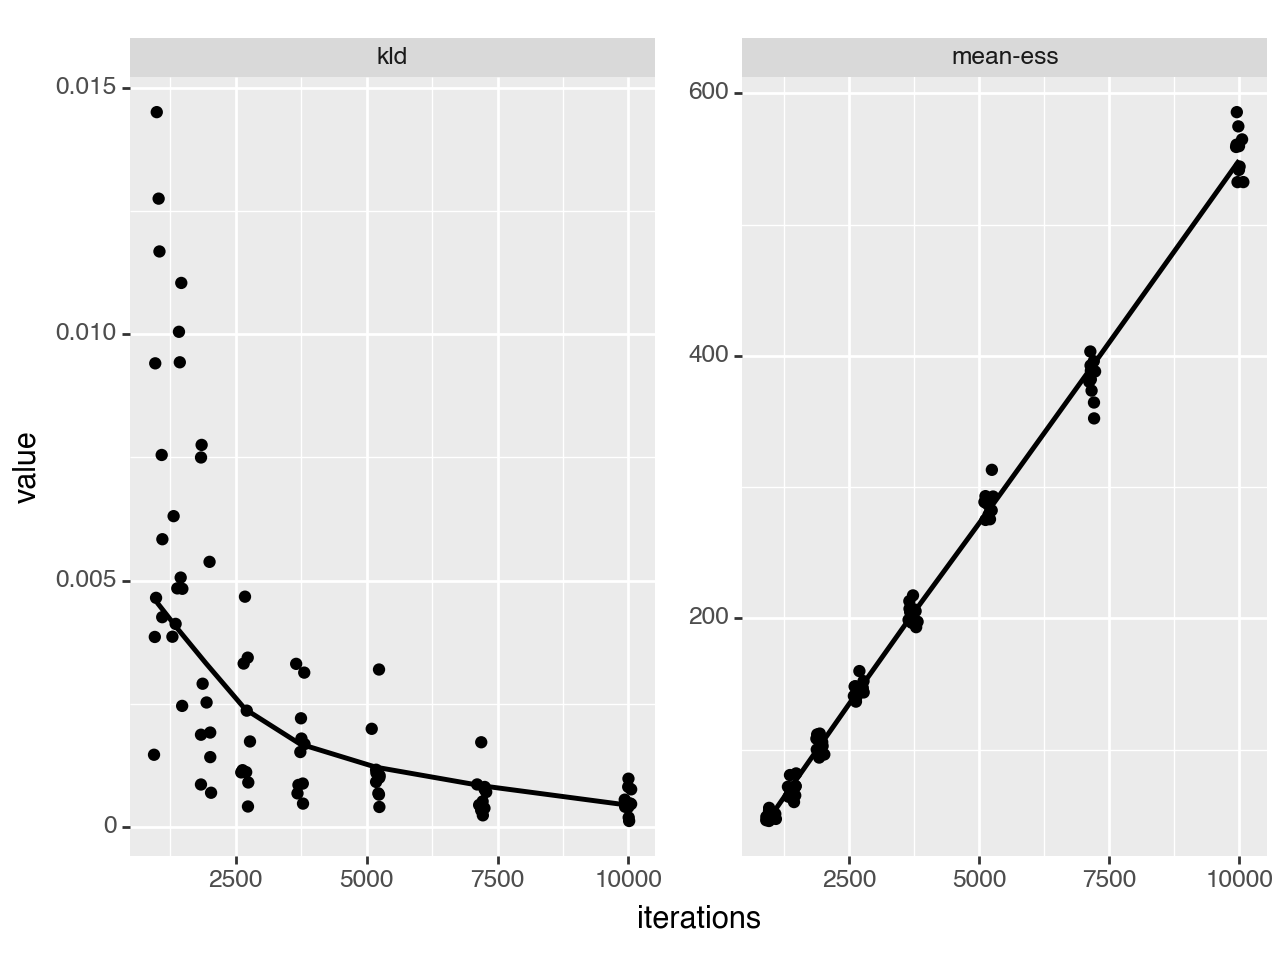

<Figure Size: (640 x 480)>

In [5]:
(ggplot(df, aes(x='iterations', y='value'))
 + geom_jitter(width=100) 
 + geom_smooth(stat='smooth', se=False)
 + facet_wrap('variable', scales='free')
 + theme(subplots_adjust={'wspace': 0.25})
)

The ESS and KLD both trend in the correct directions.

Show example run results.

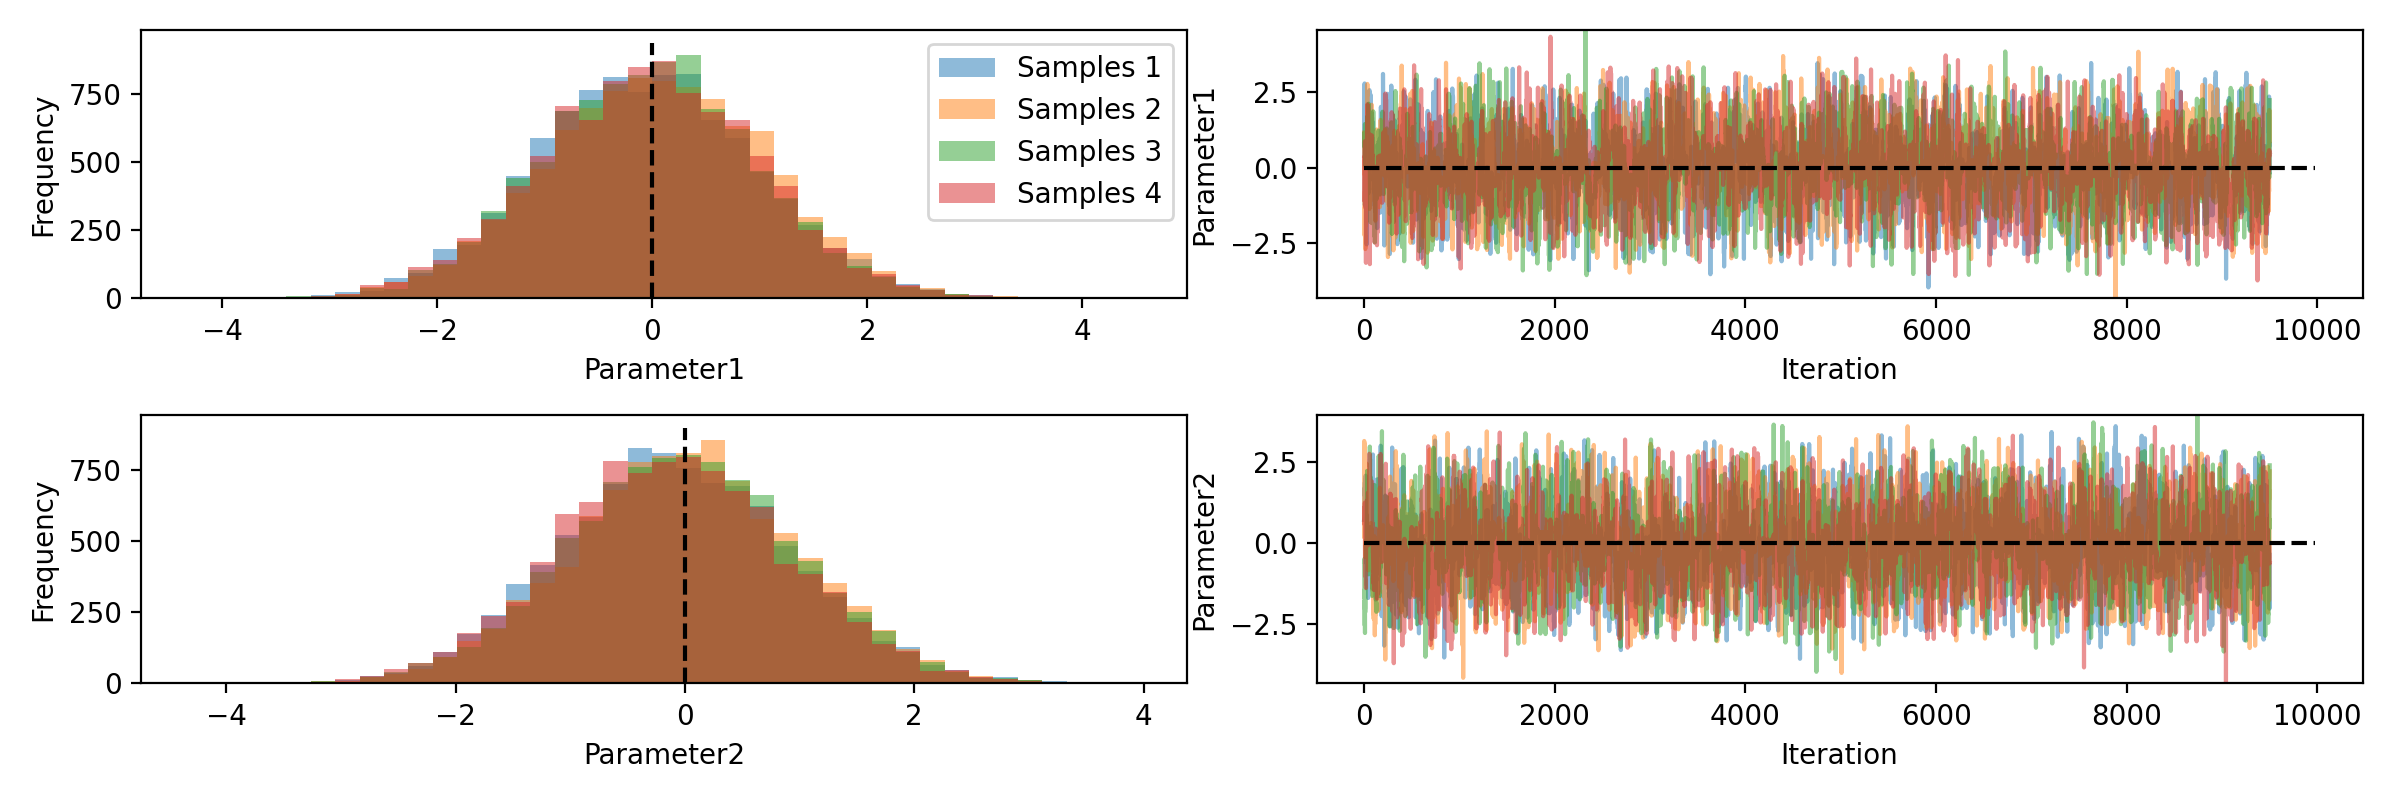

param    mean    std.    2.5%    25%    50%    75%    97.5%    rhat    ess      ess per sec.
-------  ------  ------  ------  -----  -----  -----  -------  ------  -------  --------------
param 1  -0.03   1.02    -2.03   -0.73  -0.02  0.67   1.97     1.00    2024.17  133.78
param 2  -0.05   1.00    -2.01   -0.73  -0.06  0.61   1.93     1.00    2224.78  147.04


In [6]:
n_chains = 4
n_iterations = 10000
n_warmup = 500
log_pdf = pints.toy.GaussianLogPDF(mean=[0, 0], sigma=[1, 1])

# Get initial parameters
log_prior = pints.ComposedLogPrior(
    pints.GaussianLogPrior(mean=0, sd=10),
    pints.GaussianLogPrior(mean=0, sd=10))
x0 = log_prior.sample(n=n_chains)
controller = pints.MCMCController(
            log_pdf, n_chains, x0, method=pints.RelativisticMCMC)
controller.set_max_iterations(n_iterations)
controller.set_log_to_screen(False)

for sampler in controller.samplers():
    sampler.set_hyper_parameters([20, 1, 0.1, 10])

chains = controller.run()
chains = chains[:, n_warmup:]

# Show traces and histograms
pints.plot.trace(chains, ref_parameters=[0, 0])

# Show graphs
plt.show()

results = pints.MCMCSummary(chains=chains, time=controller.time())
print(results)

The parameters are close to their true means. How do they compare to MCMC eCDFs compare with the theoretical? Look pretty good.

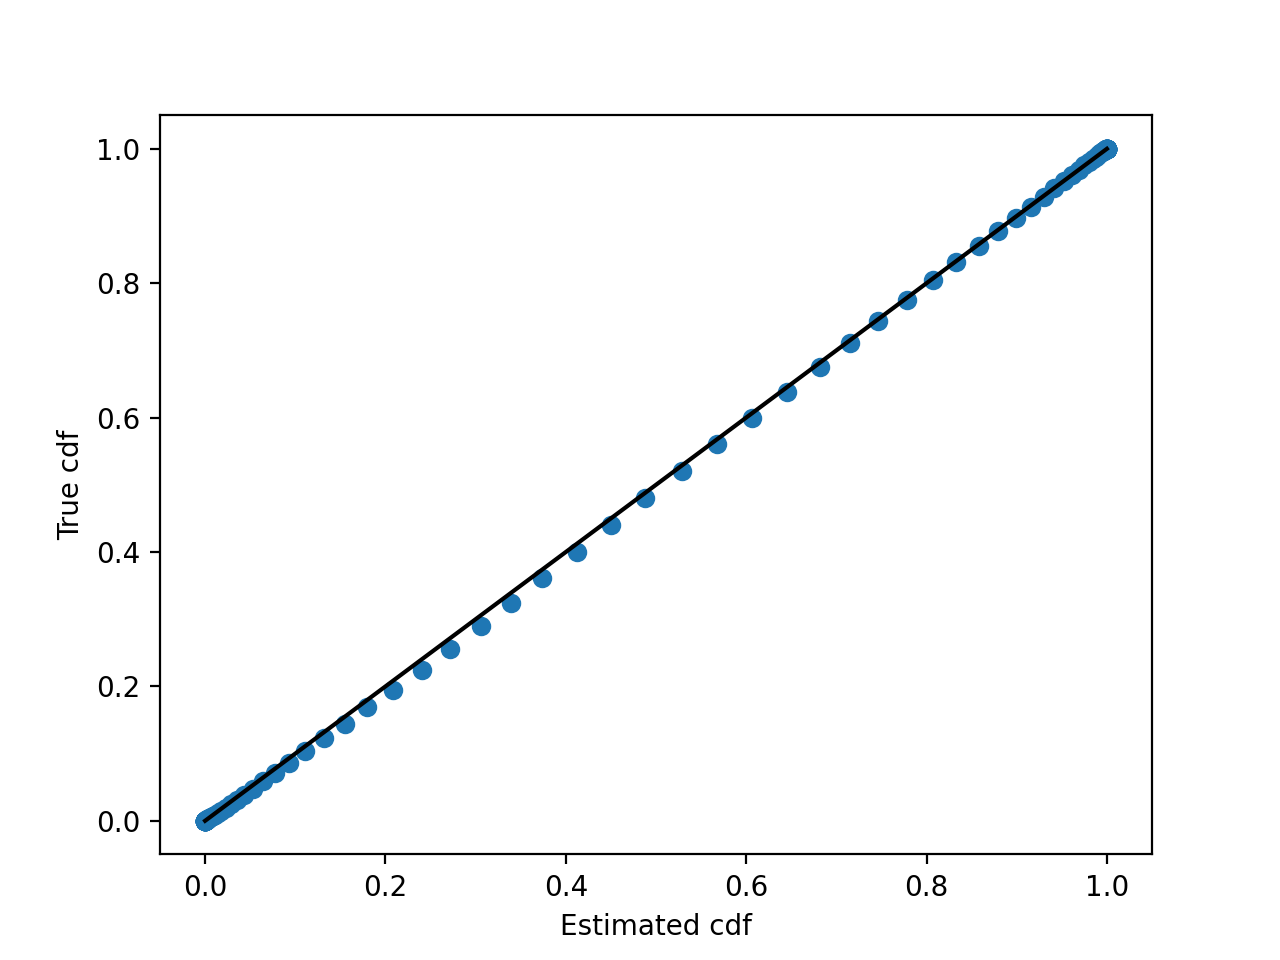

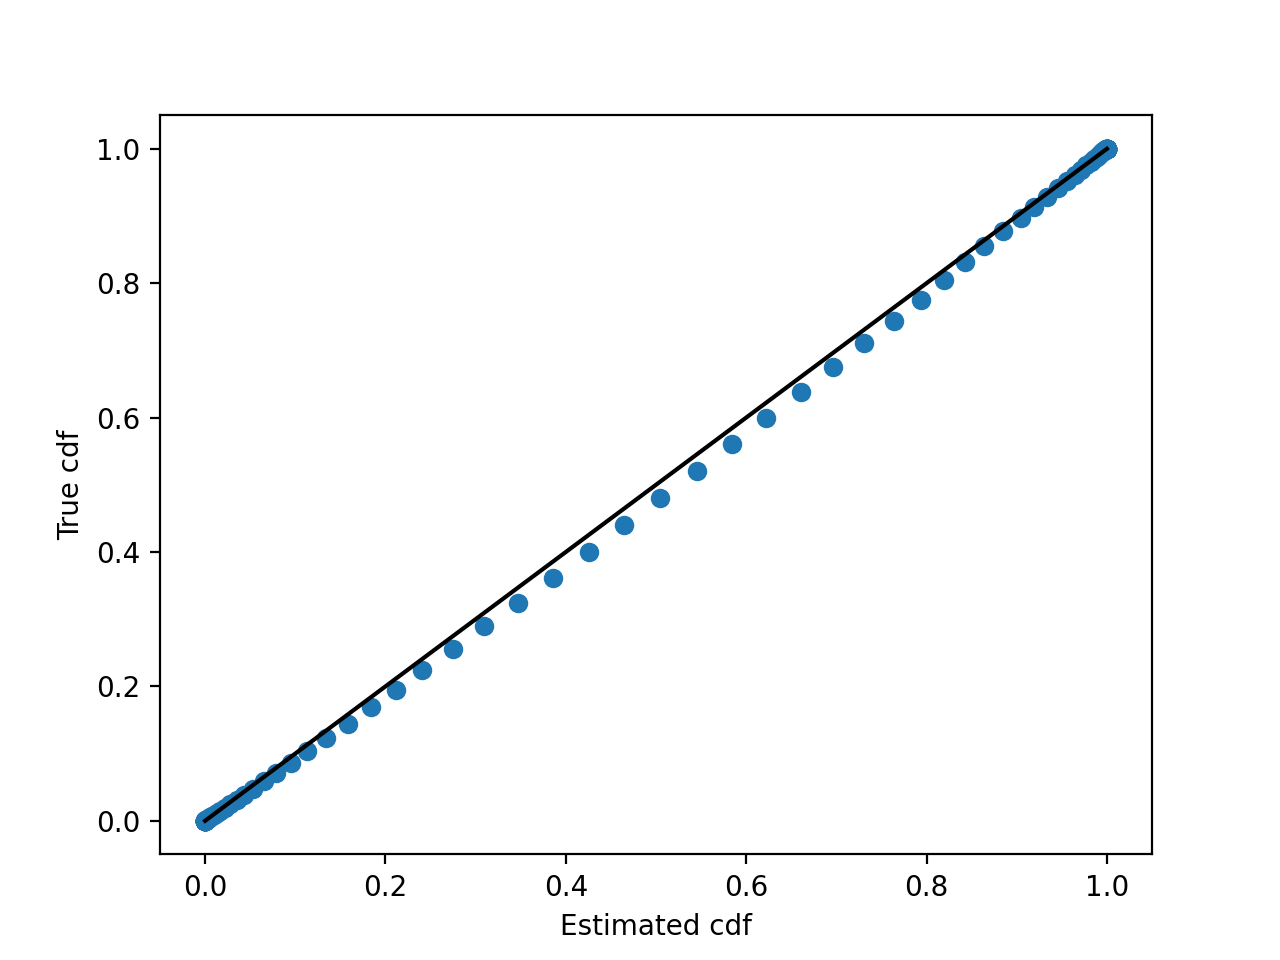

[None, None]

In [7]:
draws = np.vstack(chains)
[ecdf_norm_plotter(draws[:, i], 1) for i in range(2)]

# Correlated Gaussian

In [8]:
test = run_replicates(np.geomspace(1000, 5000, 8), 10,
                      relativistic.correlated_gaussian,
                      parallel=True)

df = pd.melt(test, id_vars=['iterations', 'replicate'])

/Users/richard/anaconda3/envs/py39/lib/python3.9/site-packages/plotnine/themes/themeable.py:1902: FutureWarning: You no longer need to use subplots_adjust to make space for the legend or text around the panels. This paramater will be removed in a future version. You can still use 'plot_margin' 'panel_spacing' for your other spacing needs.


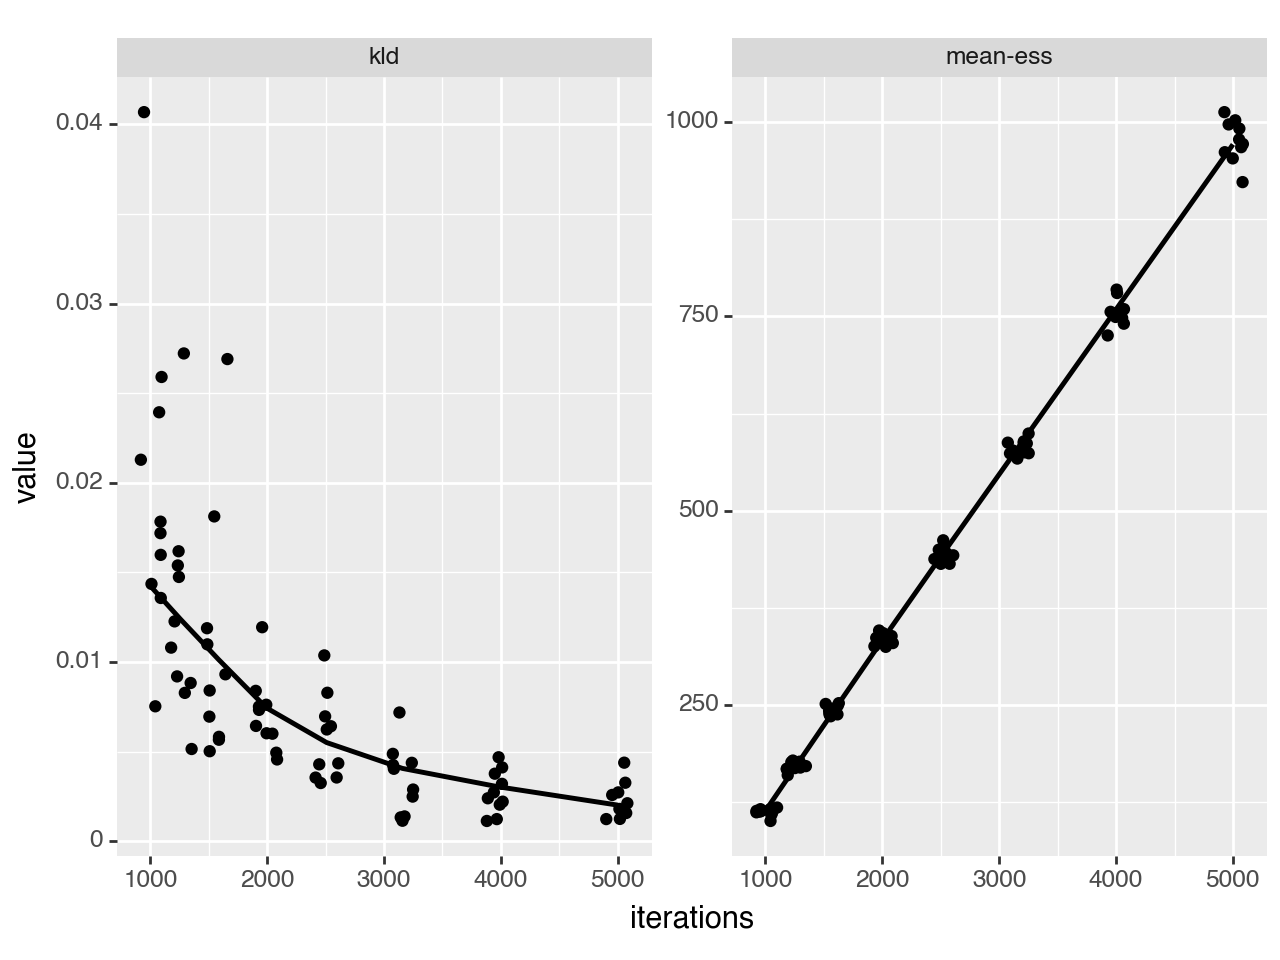

<Figure Size: (640 x 480)>

In [9]:
(ggplot(df, aes(x='iterations', y='value'))
 + geom_jitter(width=100) 
 + geom_smooth(stat='smooth', se=False)
 + facet_wrap('variable', scales='free')
 + theme(subplots_adjust={'wspace': 0.25})
)

Example run of results, with a large number of iterations. With this number of iterations, we would expect the CDFs to look accurate.

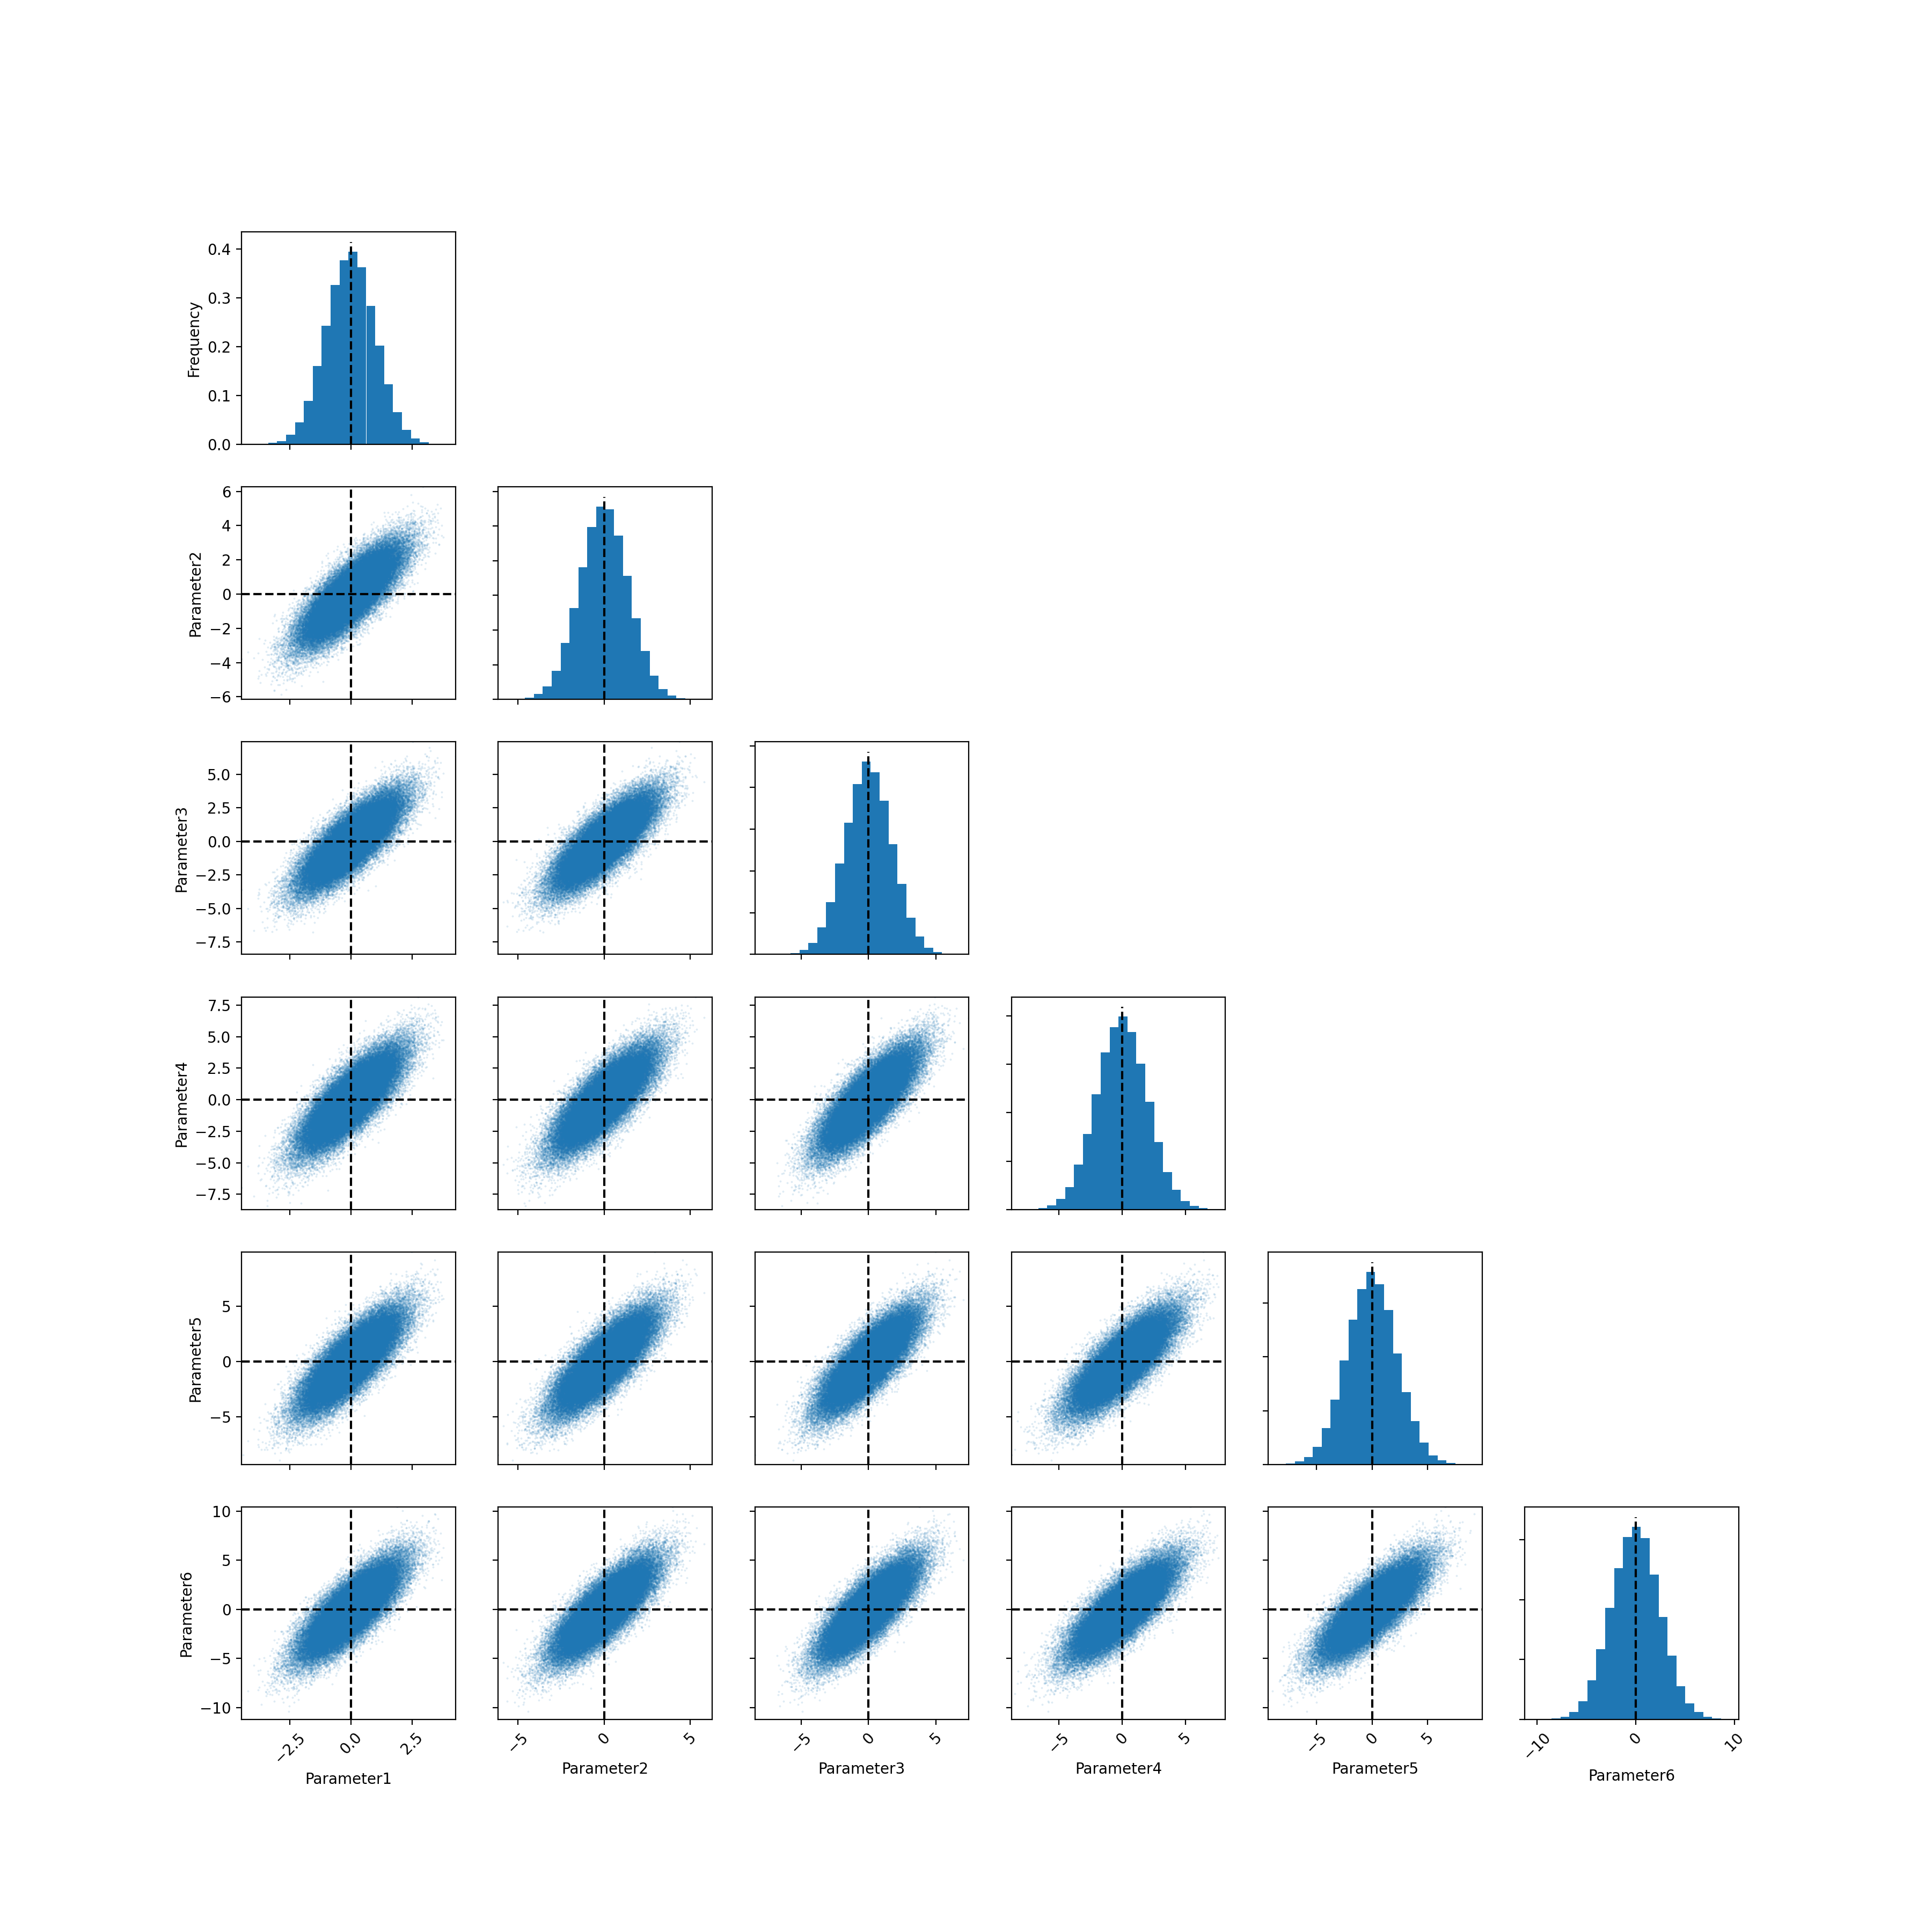

param    mean    std.    2.5%    25%    50%    75%    97.5%    rhat    ess       ess per sec.
-------  ------  ------  ------  -----  -----  -----  -------  ------  --------  --------------
param 1  -0.01   1.00    -1.96   -0.69  -0.01  0.66   1.93     1.00    18917.66  615.92
param 2  -0.01   1.41    -2.76   -0.96  -0.01  0.95   2.75     1.00    20041.16  652.50
param 3  -0.01   1.73    -3.39   -1.17  -0.01  1.15   3.37     1.00    11883.79  386.91
param 4  -0.00   1.99    -3.89   -1.35  -0.01  1.35   3.91     1.00    14747.86  480.16
param 5  -0.02   2.23    -4.40   -1.52  -0.02  1.49   4.37     1.00    17591.76  572.76
param 6  -0.02   2.45    -4.79   -1.68  -0.02  1.63   4.79     1.00    18964.59  617.45


In [10]:
n_chains = 4
n_iterations = 20000
n_warmup = 500

log_pdf = pints.toy.HighDimensionalGaussianLogPDF(dimension=6, rho=0.8)
x0 = np.random.uniform(-4, 4, size=(n_chains, 6))
controller = pints.MCMCController(
            log_pdf, n_chains, x0, sigma0=None, method=pints.RelativisticMCMC)
controller.set_max_iterations(n_iterations)
controller.set_log_to_screen(False)

for sampler in controller.samplers():
    sampler.set_hyper_parameters([20, 1, 0.1, 10])

chains = controller.run()
chains = chains[:, n_warmup:]

# Show traces and histograms
pints.plot.pairwise(np.vstack(chains), kde=False, ref_parameters=([0] * 6))

# Show graphs
plt.show()

results = pints.MCMCSummary(chains=chains, time=controller.time())
print(results)

Again the estimated means compare well with the theoretical. Now comparing the theoretical and empirical cdfs: again, these look fine.

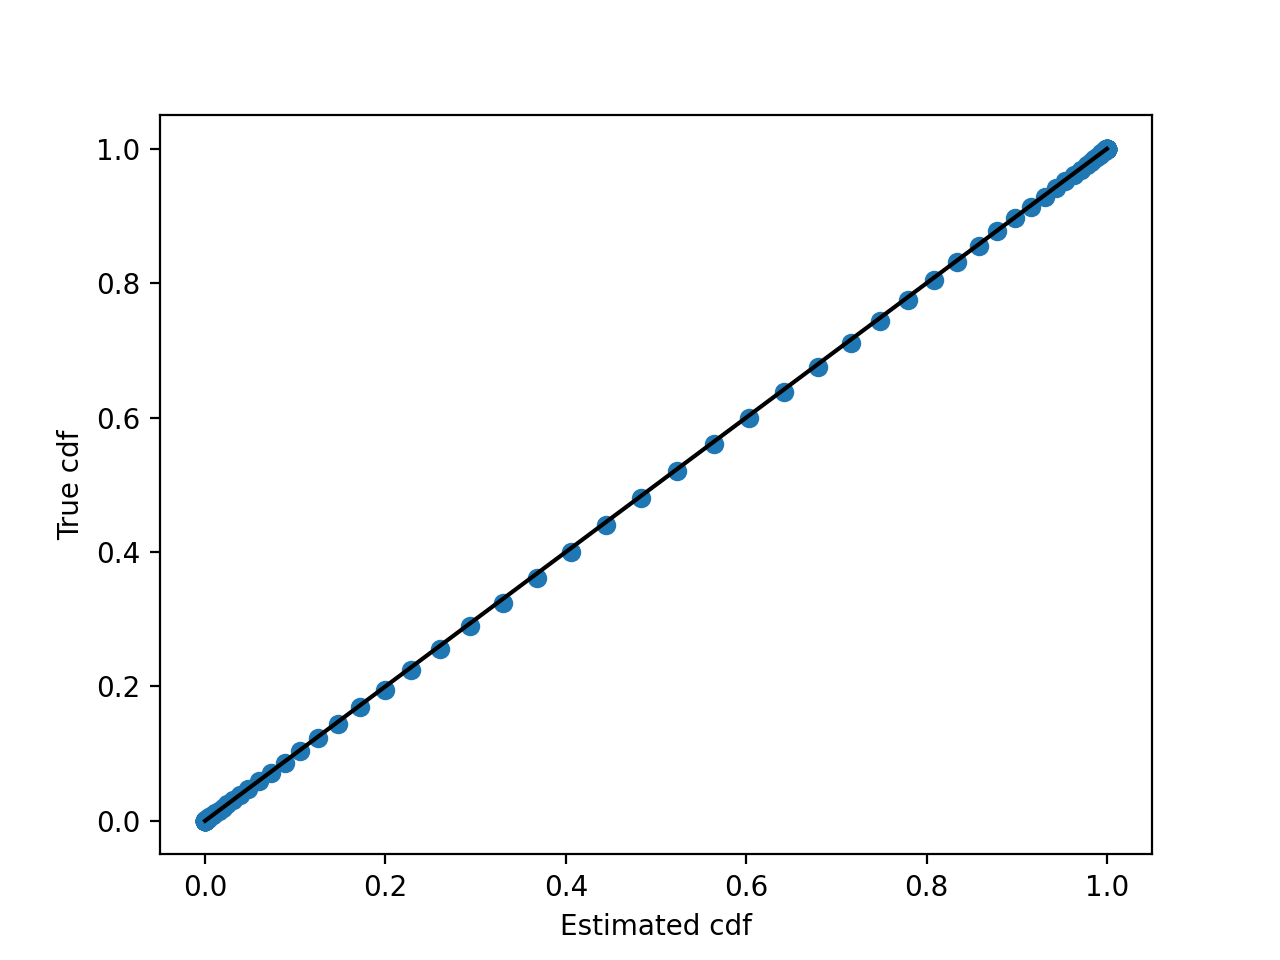

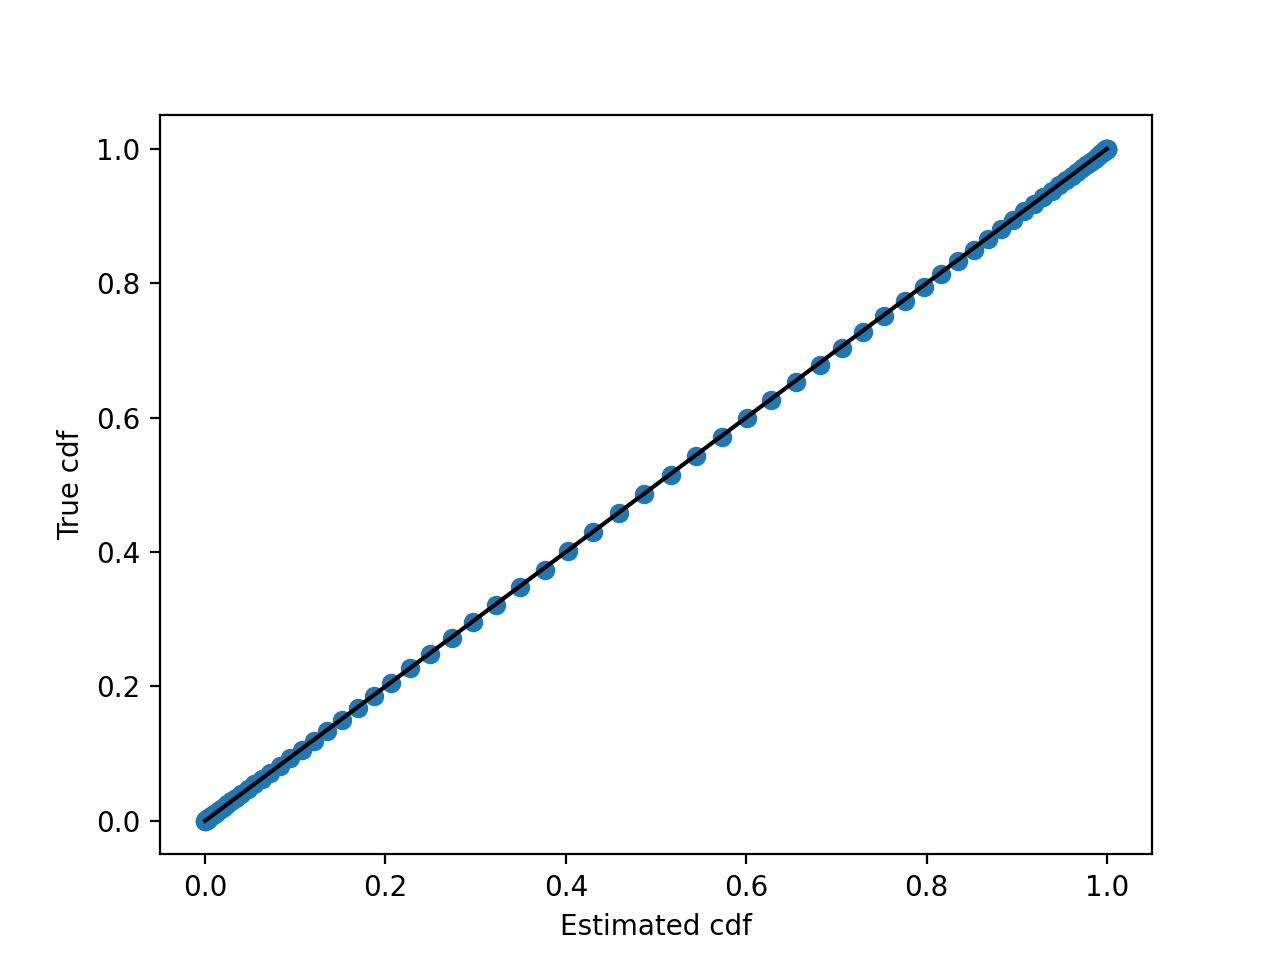

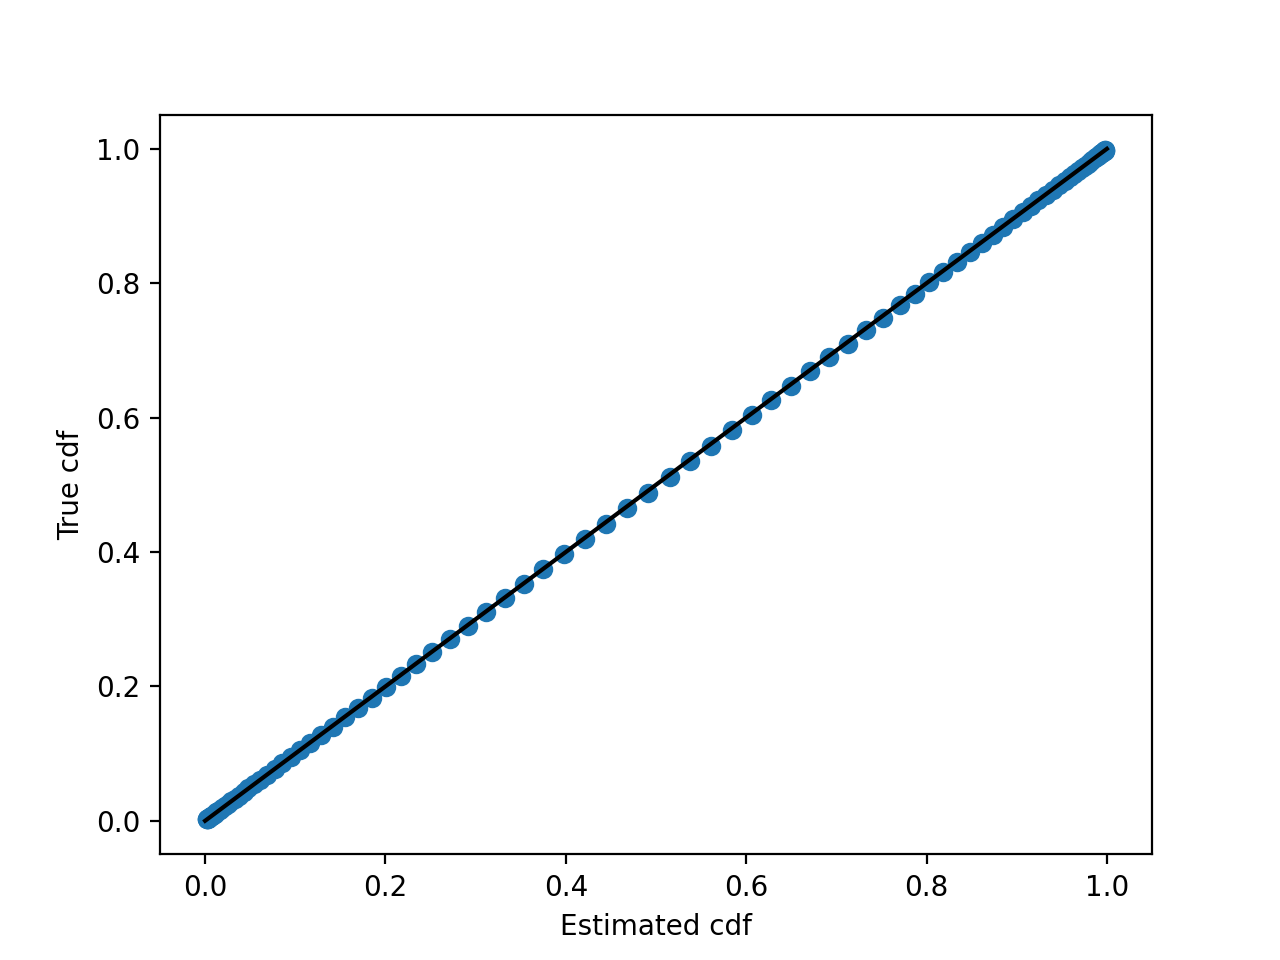

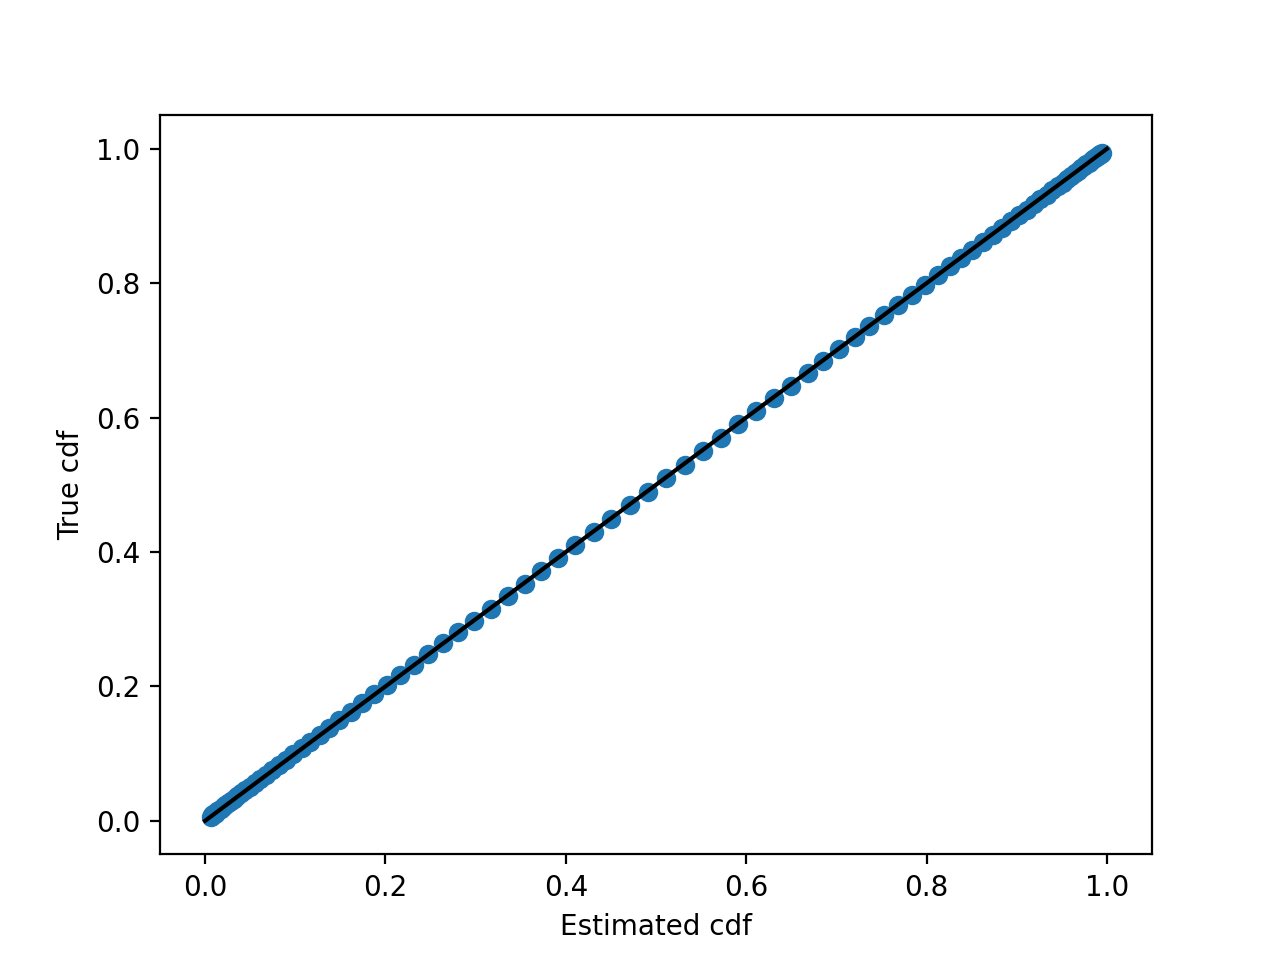

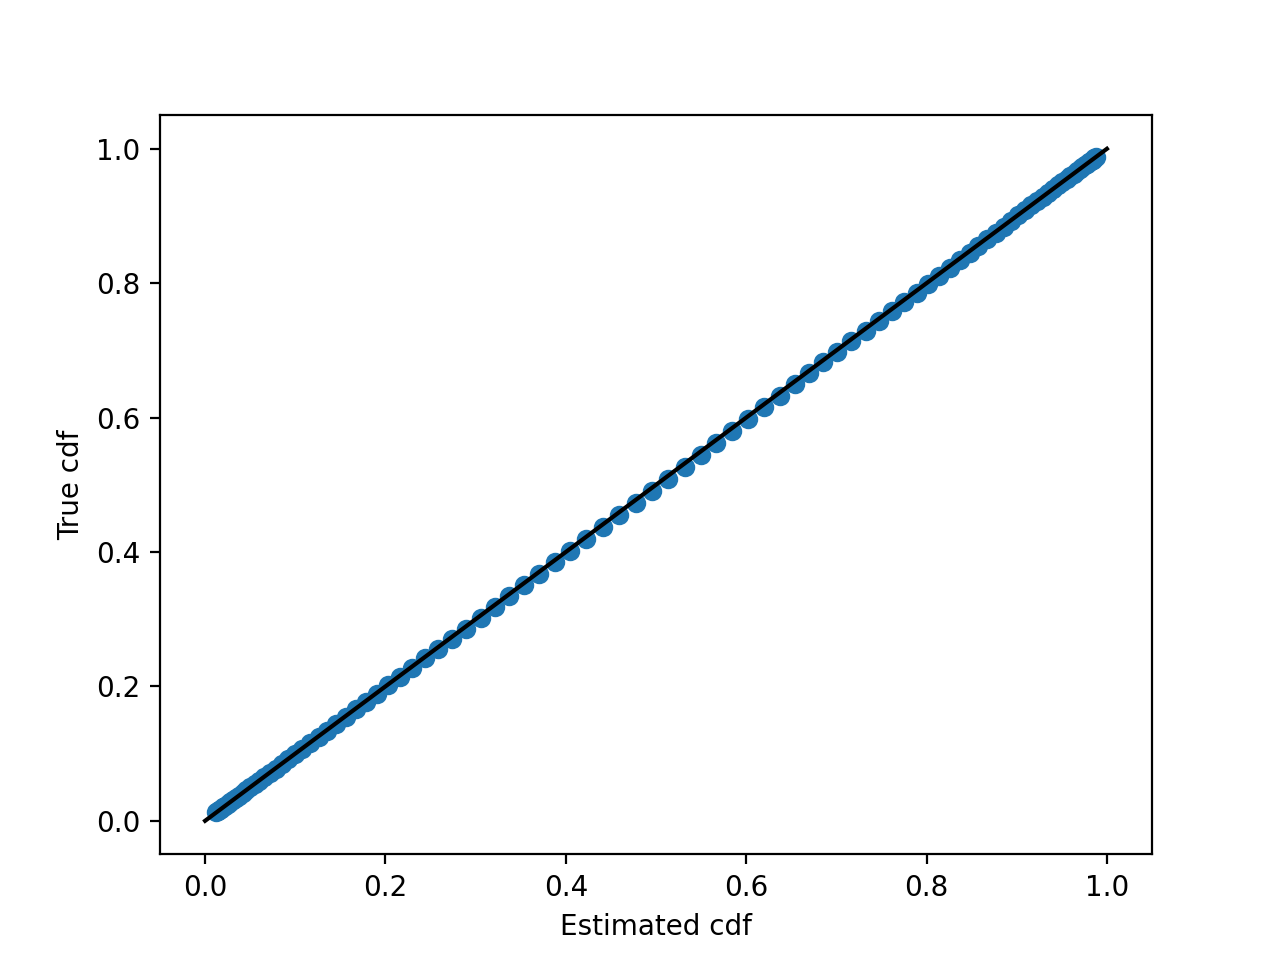

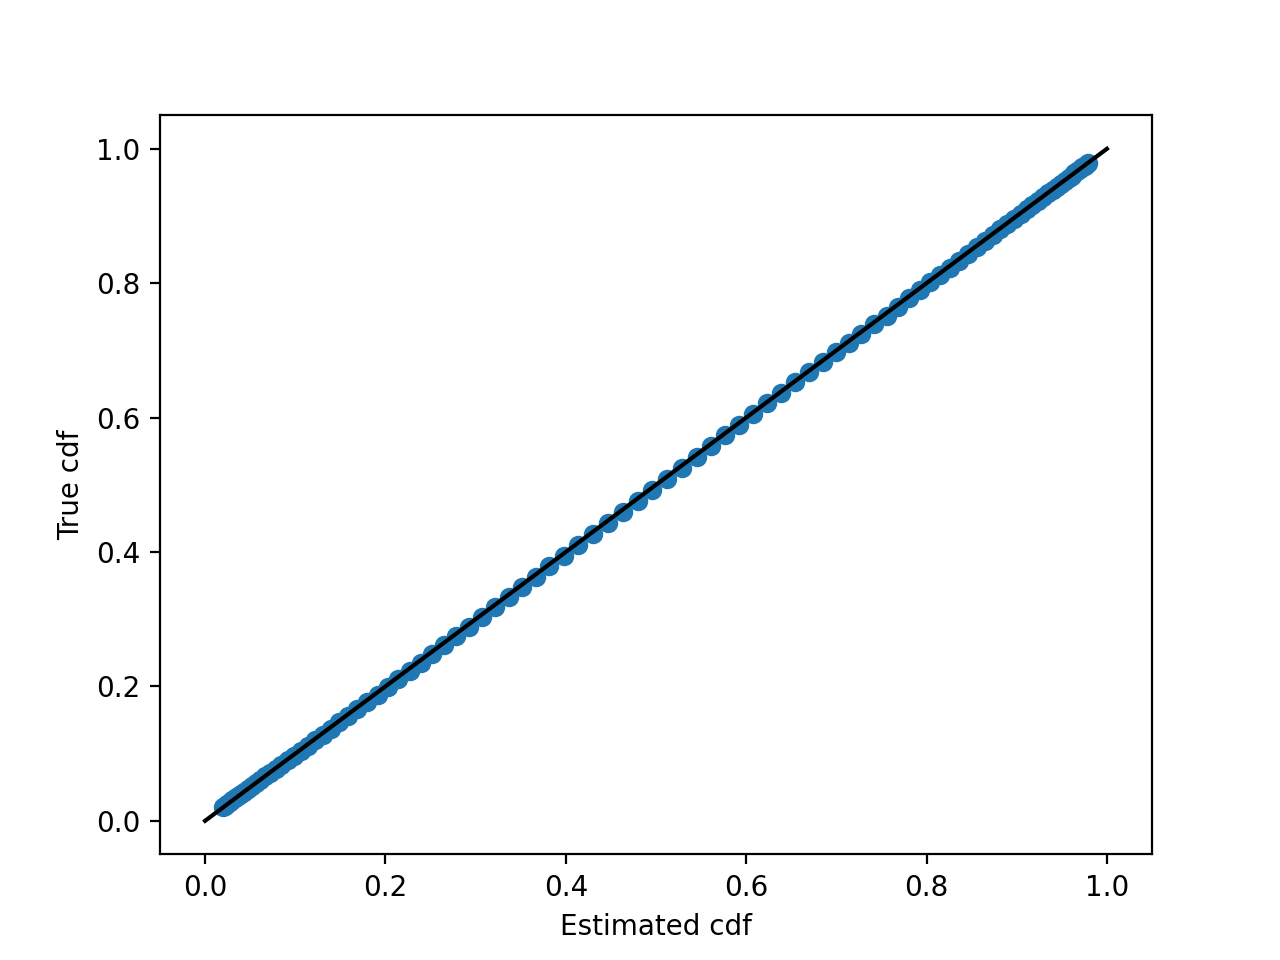

[None, None, None, None, None, None]

In [11]:
draws = np.vstack(chains)
[ecdf_norm_plotter(draws[:, i], np.sqrt(i + 1)) for i in range(6)]

# Annulus

In [12]:
test = run_replicates(np.geomspace(1000, 10000, 8), 10,
                      relativistic.annulus,
                      parallel=True)

df = pd.melt(test, id_vars=['iterations', 'replicate'])

/Users/richard/anaconda3/envs/py39/lib/python3.9/site-packages/plotnine/themes/themeable.py:1902: FutureWarning: You no longer need to use subplots_adjust to make space for the legend or text around the panels. This paramater will be removed in a future version. You can still use 'plot_margin' 'panel_spacing' for your other spacing needs.


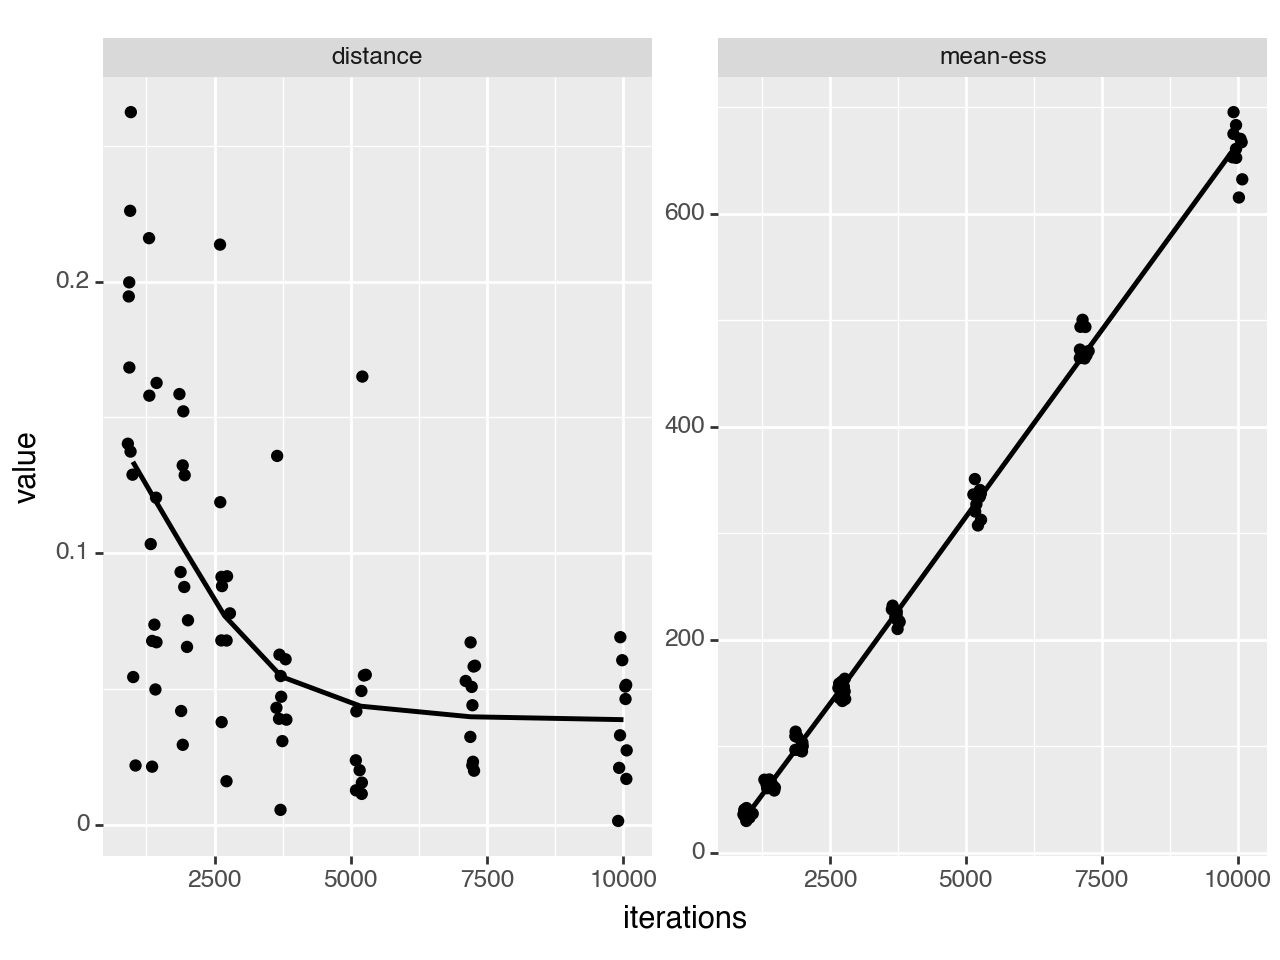

<Figure Size: (640 x 480)>

In [13]:
(ggplot(df, aes(x='iterations', y='value'))
 + geom_jitter(width=100) 
 + geom_smooth(stat='smooth', se=False)
 + facet_wrap('variable', scales='free')
 + theme(subplots_adjust={'wspace': 0.25})
)

The draws trend closer to convergence as the number of iterations increases, although distance does not improve much after 5000 iterations.

Example run.

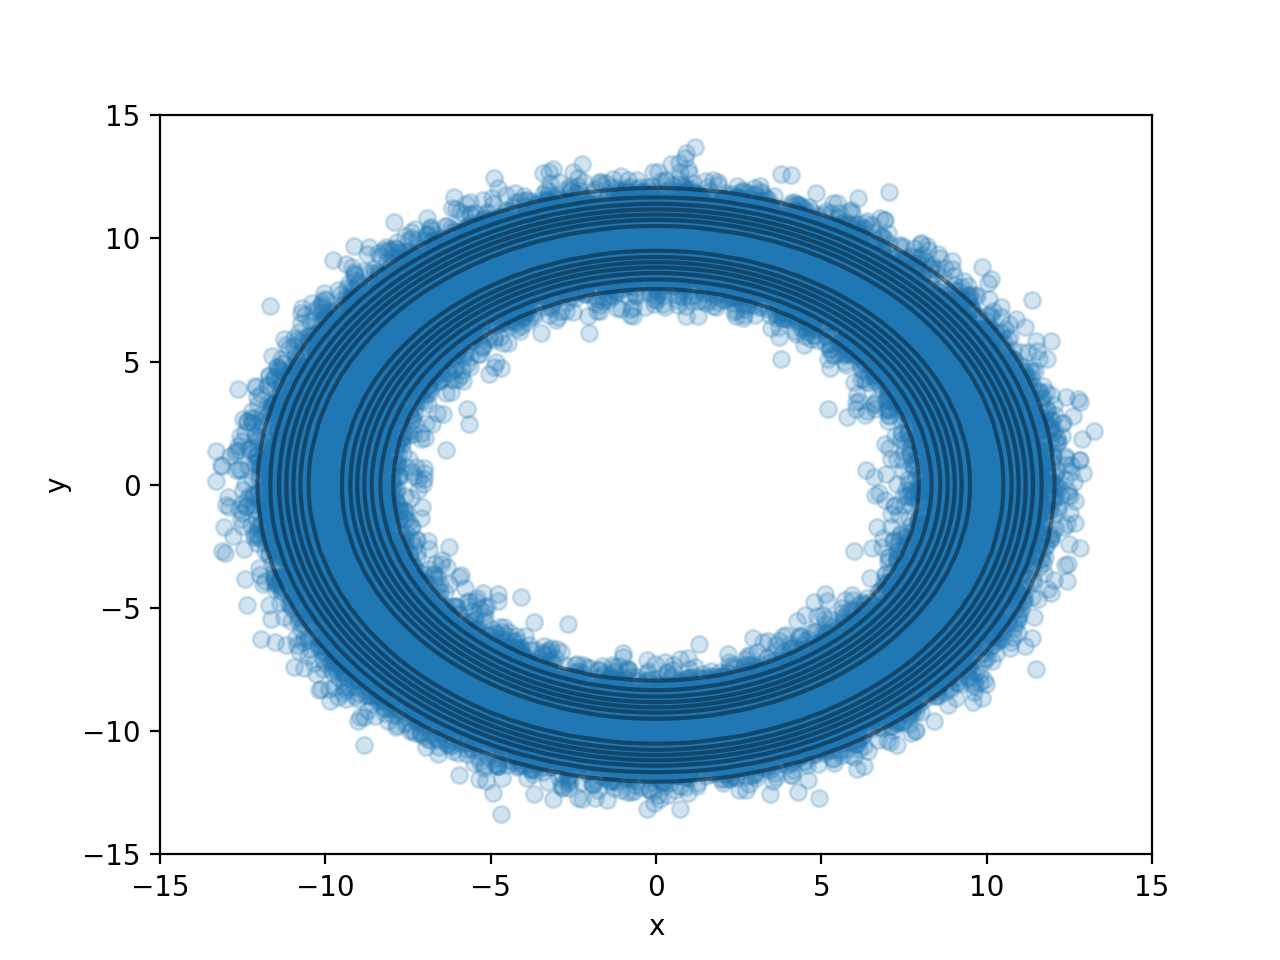

In [14]:
n_chains = 4
n_iterations = 10000
n_warmup = 500

log_pdf = pints.toy.AnnulusLogPDF()
x0 = log_pdf.sample(n_chains)

# run model
controller = pints.MCMCController(
            log_pdf, n_chains, x0, sigma0=None, method=pints.RelativisticMCMC)
controller.set_max_iterations(n_iterations)
controller.set_log_to_screen(False)

for sampler in controller.samplers():
    sampler.set_hyper_parameters([20, 1, 0.1, 10])

chains = controller.run()
chains = np.vstack(chains[:, n_warmup:])

num_points = 100
x = np.linspace(-15, 15, num_points)
y = np.linspace(-15, 15, num_points)
X, Y = np.meshgrid(x, y)
Z = np.zeros(X.shape)
Z = np.exp([[log_pdf([i, j]) for i in x] for j in y])
plt.contour(X, Y, Z, colors='k', alpha=0.4)
plt.scatter(chains[:, 0], chains[:, 1], alpha=0.2)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

# Cone

In [21]:
test = run_replicates(np.geomspace(1000, 10000, 8), 10,
                      relativistic.cone,
                      parallel=True)

df = pd.melt(test, id_vars=['iterations', 'replicate'])

/Users/richard/anaconda3/envs/py39/lib/python3.9/site-packages/plotnine/themes/themeable.py:1902: FutureWarning: You no longer need to use subplots_adjust to make space for the legend or text around the panels. This paramater will be removed in a future version. You can still use 'plot_margin' 'panel_spacing' for your other spacing needs.


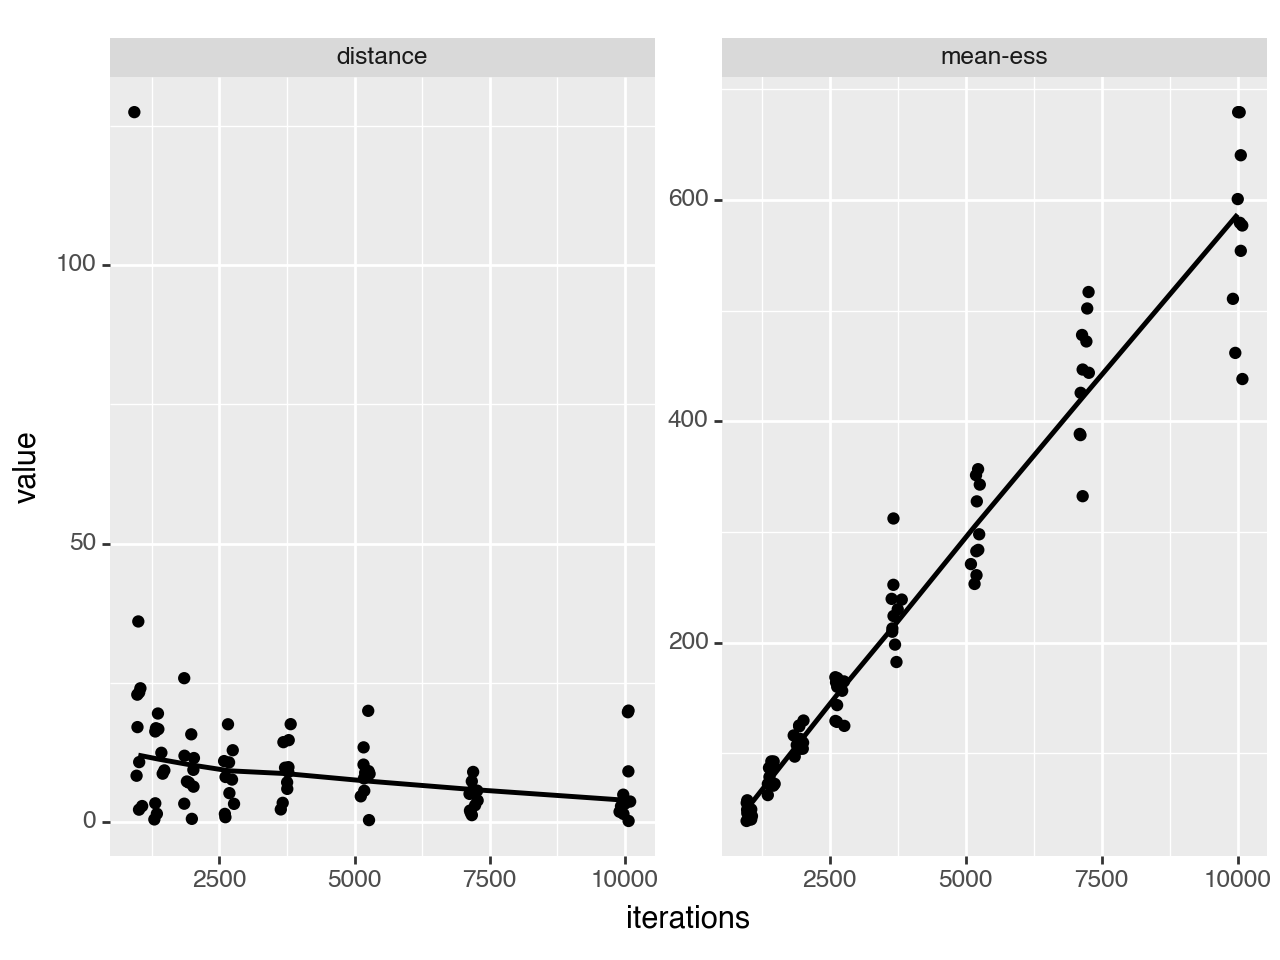

<Figure Size: (640 x 480)>

In [22]:
(ggplot(df, aes(x='iterations', y='value'))
 + geom_jitter(width=100) 
 + geom_smooth(stat='smooth', se=False)
 + facet_wrap('variable', scales='free')
 + theme(subplots_adjust={'wspace': 0.25})
)

Again, the cone problem, with its long tails, is really hard. Distance does not improve much with more iterations.

Now showing an example run.

Running...
Done!
param       mean    std.    2.5%    25%    50%    75%    97.5%    rhat    ess      ess per sec.
----------  ------  ------  ------  -----  -----  -----  -------  ------  -------  --------------
mean dim 1  0.04    8.66    -18.08  -3.49  0.02   3.57   18.60    1.00    2434.72  270.10
mean dim 2  -0.00   8.62    -18.65  -3.50  0.03   3.56   18.28    1.00    2646.45  293.58


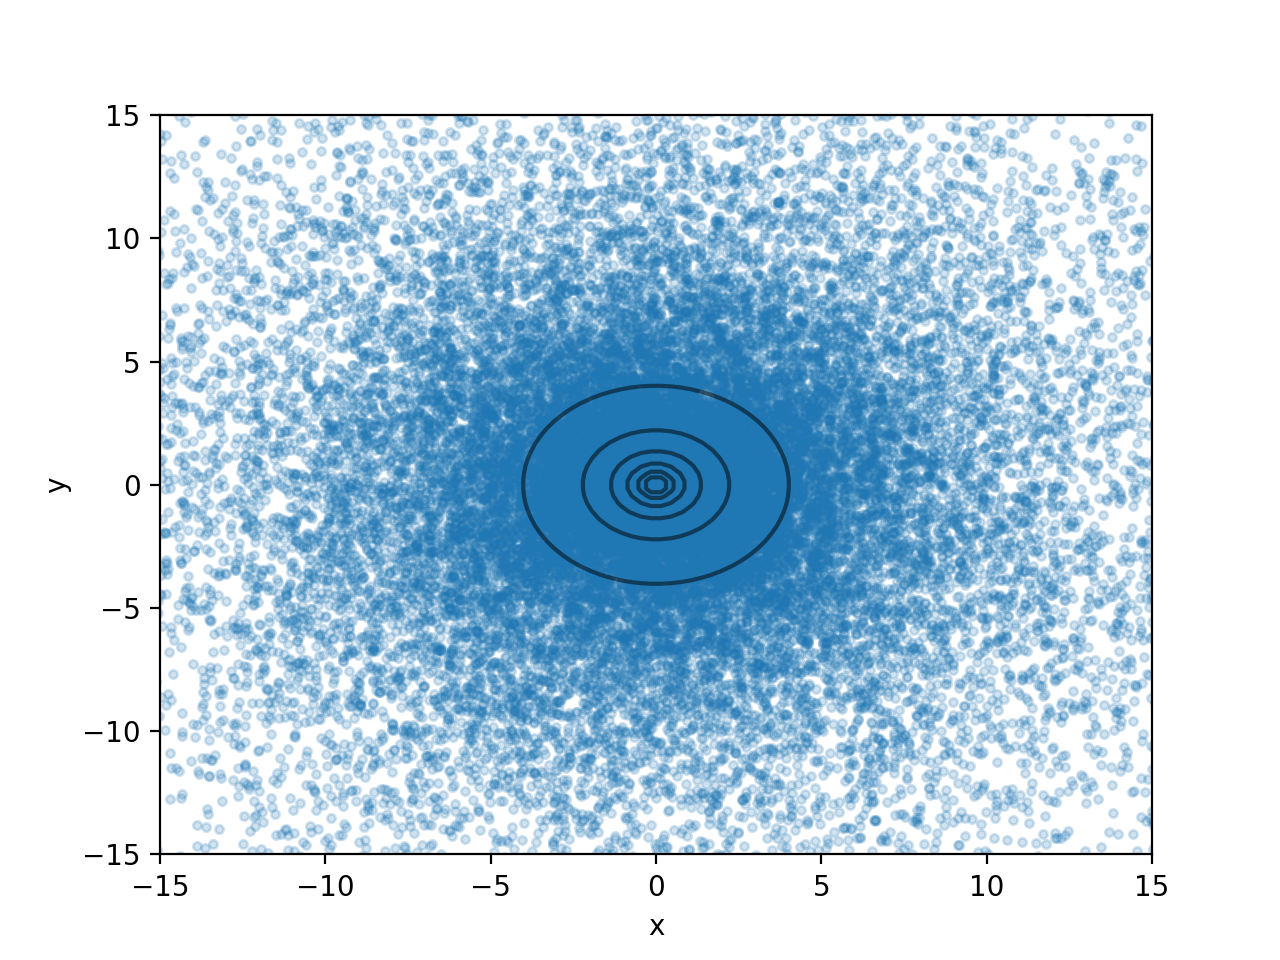

True normed mean = 8.638816024714002
Sample normed mean = 8.967885785837264
True normed var = 65.40423915068341
Sample normed var = 70.62078818529585


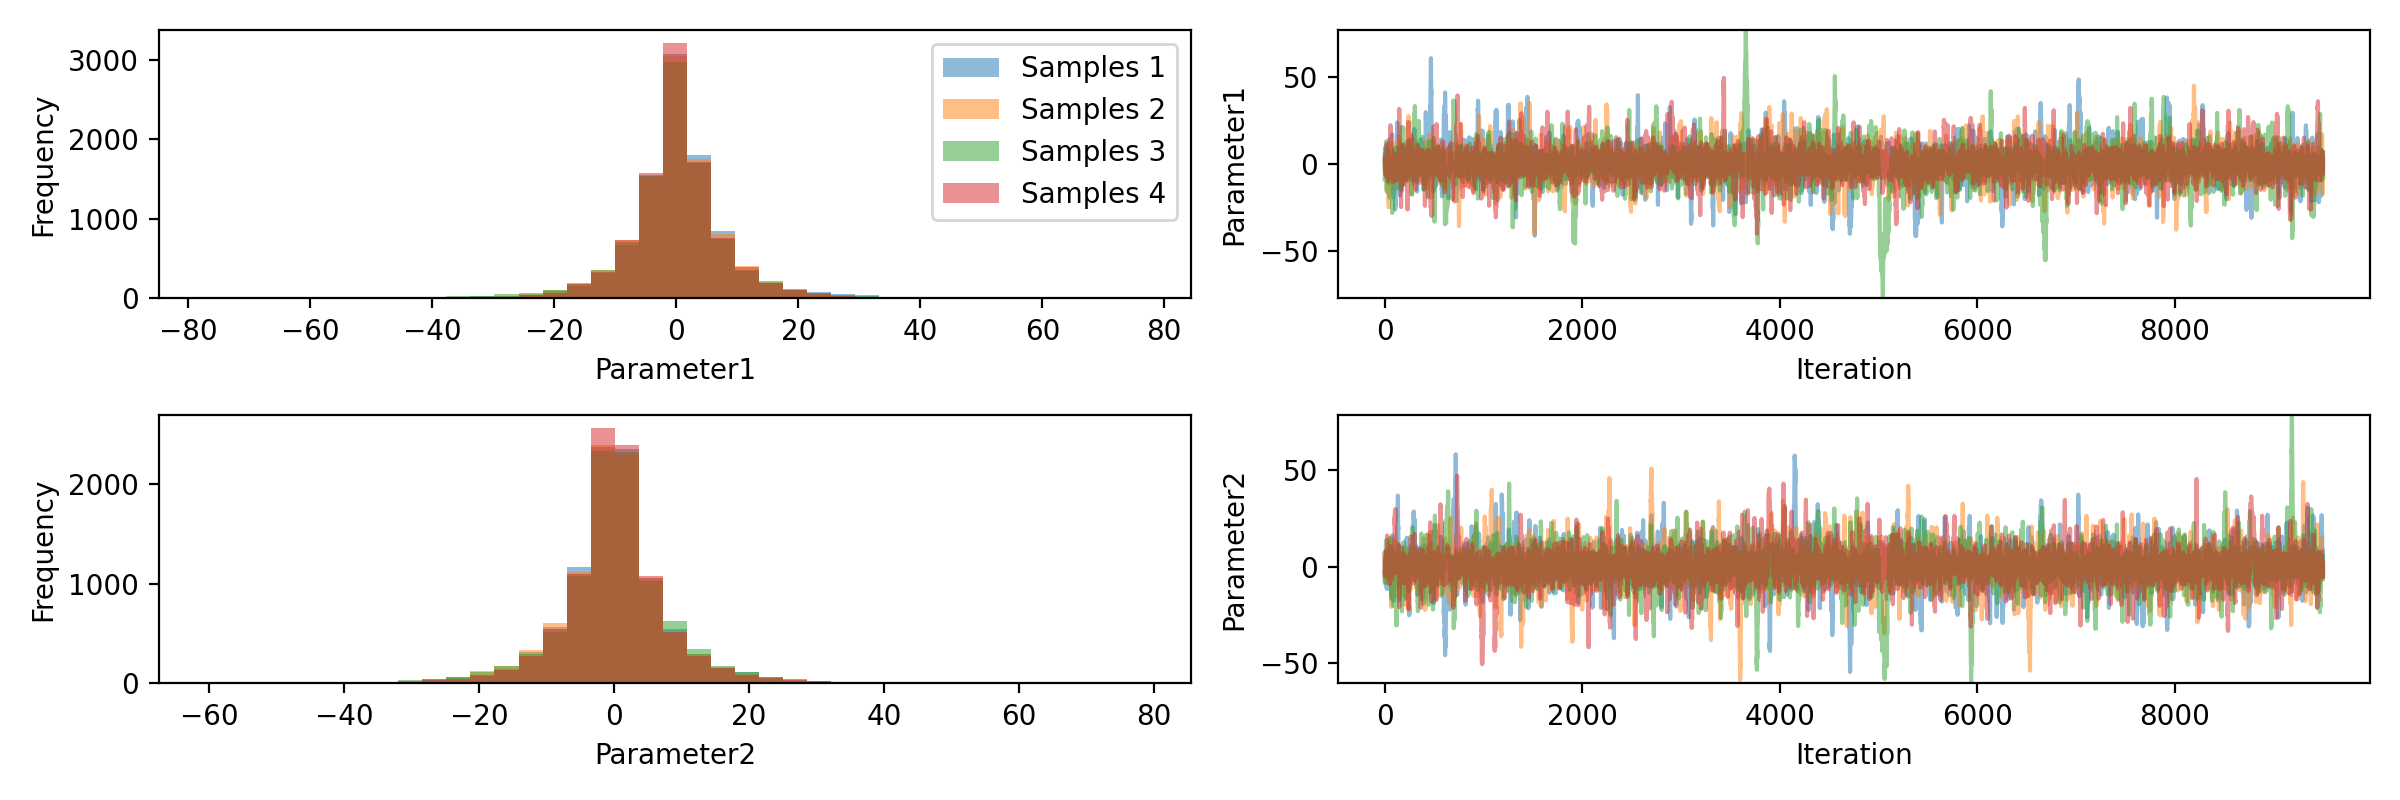

In [23]:
nchains = 4
log_pdf = pints.toy.ConeLogPDF(dimensions=2, beta=0.6)
x0 = log_pdf.sample(nchains)
mcmc = pints.MCMCController(log_pdf, nchains, x0, method=pints.RelativisticMCMC)

# Set maximum number of iterations
mcmc.set_max_iterations(10000)

# Disable logging
mcmc.set_log_to_screen(False)

for sampler in mcmc.samplers():
    sampler.set_hyper_parameters([20, 1, 0.1, 10])

# Run!
print('Running...')
chains = mcmc.run()
print('Done!')

# Check convergence and other properties of chains
results = pints.MCMCSummary(chains=chains, time=mcmc.time(),
                            parameter_names=['mean dim 1', 'mean dim 2'])
print(results)

# Discard warm-up
chains = [chain[500:] for chain in chains]
stacked = np.vstack(chains)

# overlay draws on contours
num_points = 100
x = np.linspace(-15, 15, num_points)
y = np.linspace(-15, 15, num_points)
X, Y = np.meshgrid(x, y)
Z = np.zeros(X.shape)
Z = np.exp([[log_pdf([i, j]) for i in x] for j in y])
plt.contour(X, Y, Z, colors='k', alpha=0.5)
plt.scatter(stacked[:,0], stacked[:,1], marker='.', alpha=0.2)
plt.xlim(-15, 15)
plt.ylim(-15, 15)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

d = list(map(lambda x: np.linalg.norm(x), stacked))
a_mean = np.mean(d)
a_var = np.var(d)

print("True normed mean = " + str(log_pdf.mean_normed()))
print("Sample normed mean = " + str(a_mean))

print("True normed var = " + str(log_pdf.var_normed()))
print("Sample normed var = " + str(a_var))

# Show traces and histograms
pints.plot.trace(chains)
plt.show()

# High dimensional Gaussian

In [24]:
test = run_replicates(np.geomspace(1000, 5000, 8), 10,
                      relativistic.high_dim_gaussian,
                      parallel=True)

df = pd.melt(test, id_vars=['iterations', 'replicate'])

/Users/richard/anaconda3/envs/py39/lib/python3.9/site-packages/plotnine/themes/themeable.py:1902: FutureWarning: You no longer need to use subplots_adjust to make space for the legend or text around the panels. This paramater will be removed in a future version. You can still use 'plot_margin' 'panel_spacing' for your other spacing needs.


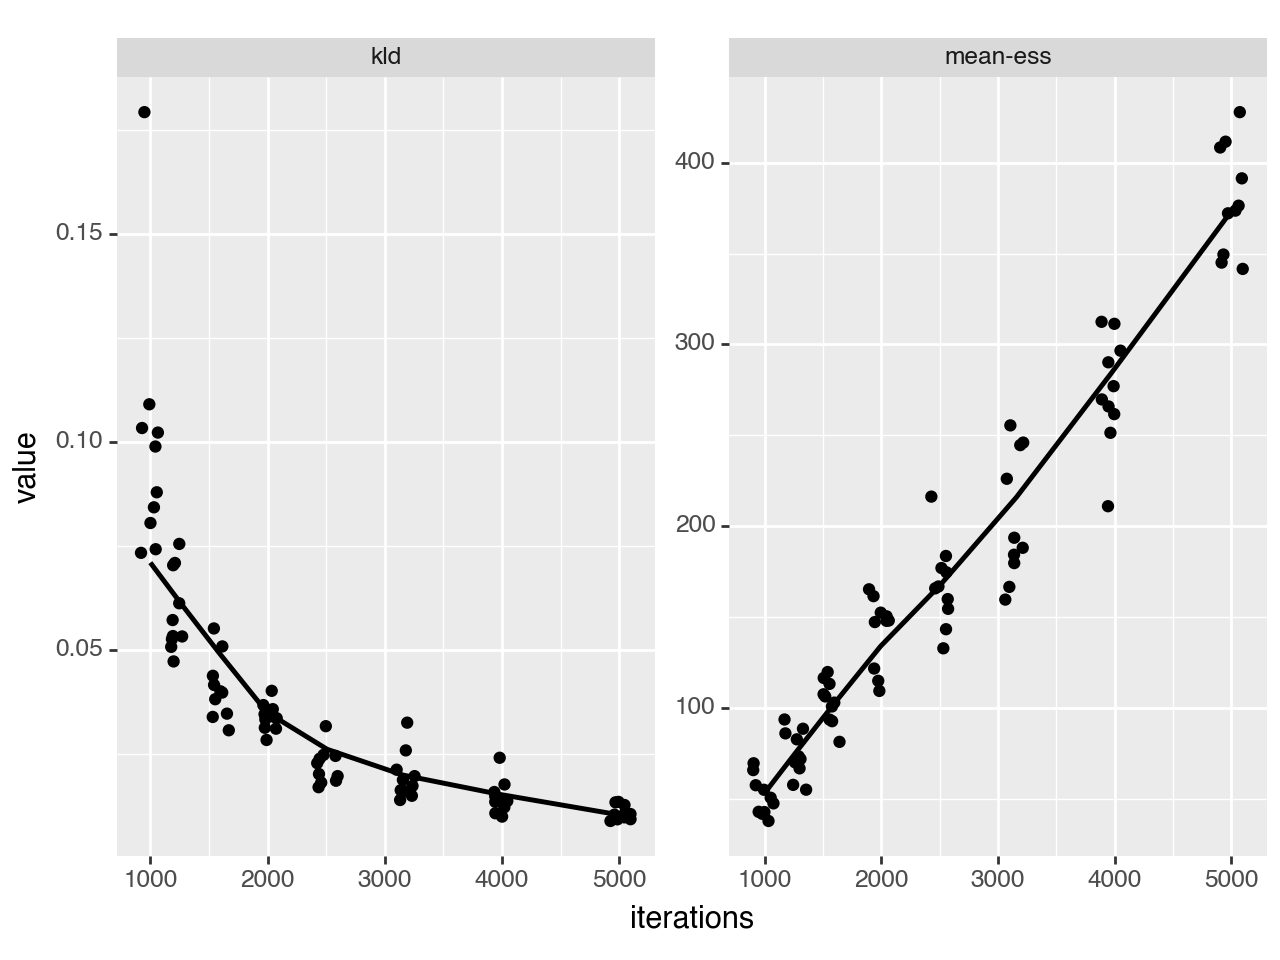

<Figure Size: (640 x 480)>

In [25]:
(ggplot(df, aes(x='iterations', y='value'))
 + geom_jitter(width=100) 
 + geom_smooth(stat='smooth', se=False)
 + facet_wrap('variable', scales='free')
 + theme(subplots_adjust={'wspace': 0.25})
)

## Multimodal Gaussian

In [26]:
test = run_replicates(np.geomspace(1000, 5000, 8), 10,
                      relativistic.multimodal_gaussian,
                      parallel=True)

df = pd.melt(test, id_vars=['iterations', 'replicate'])

/Users/richard/anaconda3/envs/py39/lib/python3.9/site-packages/plotnine/themes/themeable.py:1902: FutureWarning: You no longer need to use subplots_adjust to make space for the legend or text around the panels. This paramater will be removed in a future version. You can still use 'plot_margin' 'panel_spacing' for your other spacing needs.


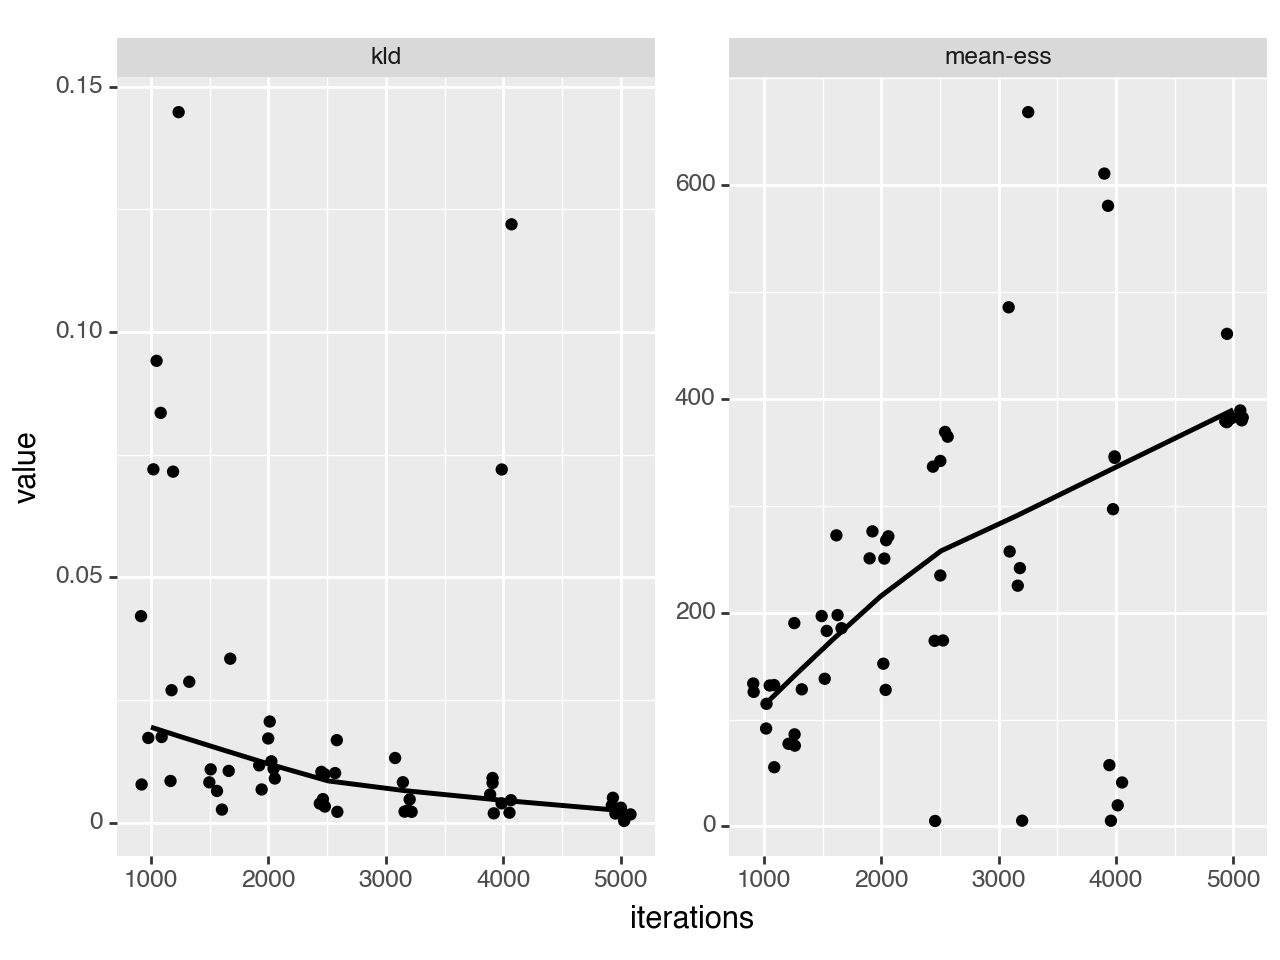

<Figure Size: (640 x 480)>

In [30]:
# remove high values of kld to see general trend
test1 = test.query('kld < 0.4')
df1 = pd.melt(test1, id_vars=['iterations', 'replicate'])

(ggplot(df1, aes(x='iterations', y='value'))
 + geom_jitter(width=100) 
 + geom_smooth(stat='smooth', se=False)
 + facet_wrap('variable', scales='free')
 + theme(subplots_adjust={'wspace': 0.25})
)

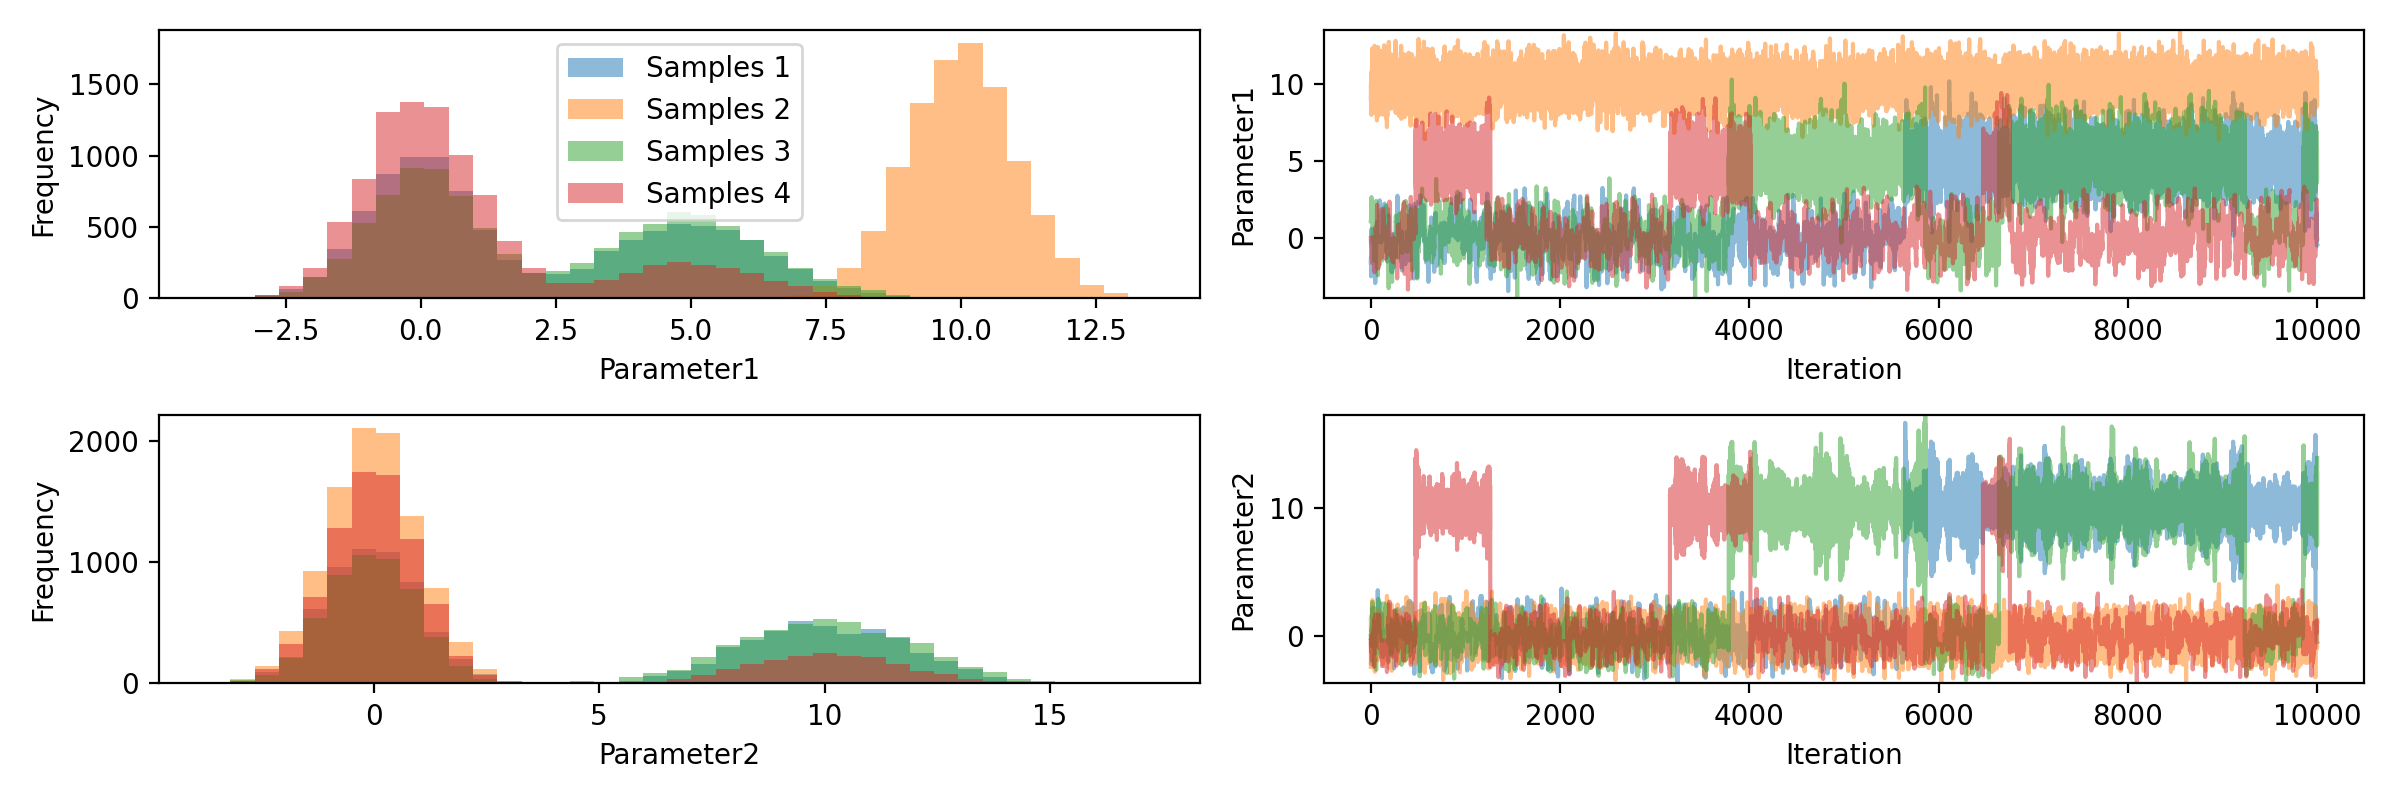

param    mean    std.    2.5%    25%    50%    75%    97.5%    rhat    ess      ess per sec.
-------  ------  ------  ------  -----  -----  -----  -------  ------  -------  --------------
param 1  3.88    4.27    -1.61   0.05   3.15   8.00   11.31    2.34    3369.51  53.10
param 2  2.76    4.67    -1.83   -0.41  0.47   7.67   12.49    1.42    3363.95  53.01


In [31]:
n_chains = 4
n_iterations = 10000
n_warmup = 500

covariances = [[[1, 0], [0, 1]],
               [[2, 0.8], [0.8, 3]],
               [[1, -0.5], [-0.5, 1]]]
log_pdf = pints.toy.MultimodalGaussianLogPDF(modes=[[0, 0], [5, 10], [10, 0]],
                                             covariances=covariances)
x0 = log_pdf.sample(n_chains)

# run model
controller = pints.MCMCController(
            log_pdf, n_chains, x0, sigma0=None, method=pints.RelativisticMCMC)
controller.set_max_iterations(n_iterations)
controller.set_log_to_screen(False)

for sampler in controller.samplers():
    sampler.set_hyper_parameters([20, 1, 0.1, 10])

chains = controller.run()

pints.plot.trace(chains)

# Show graphs
plt.show()

results = pints.MCMCSummary(chains=chains, time=controller.time())
print(results)



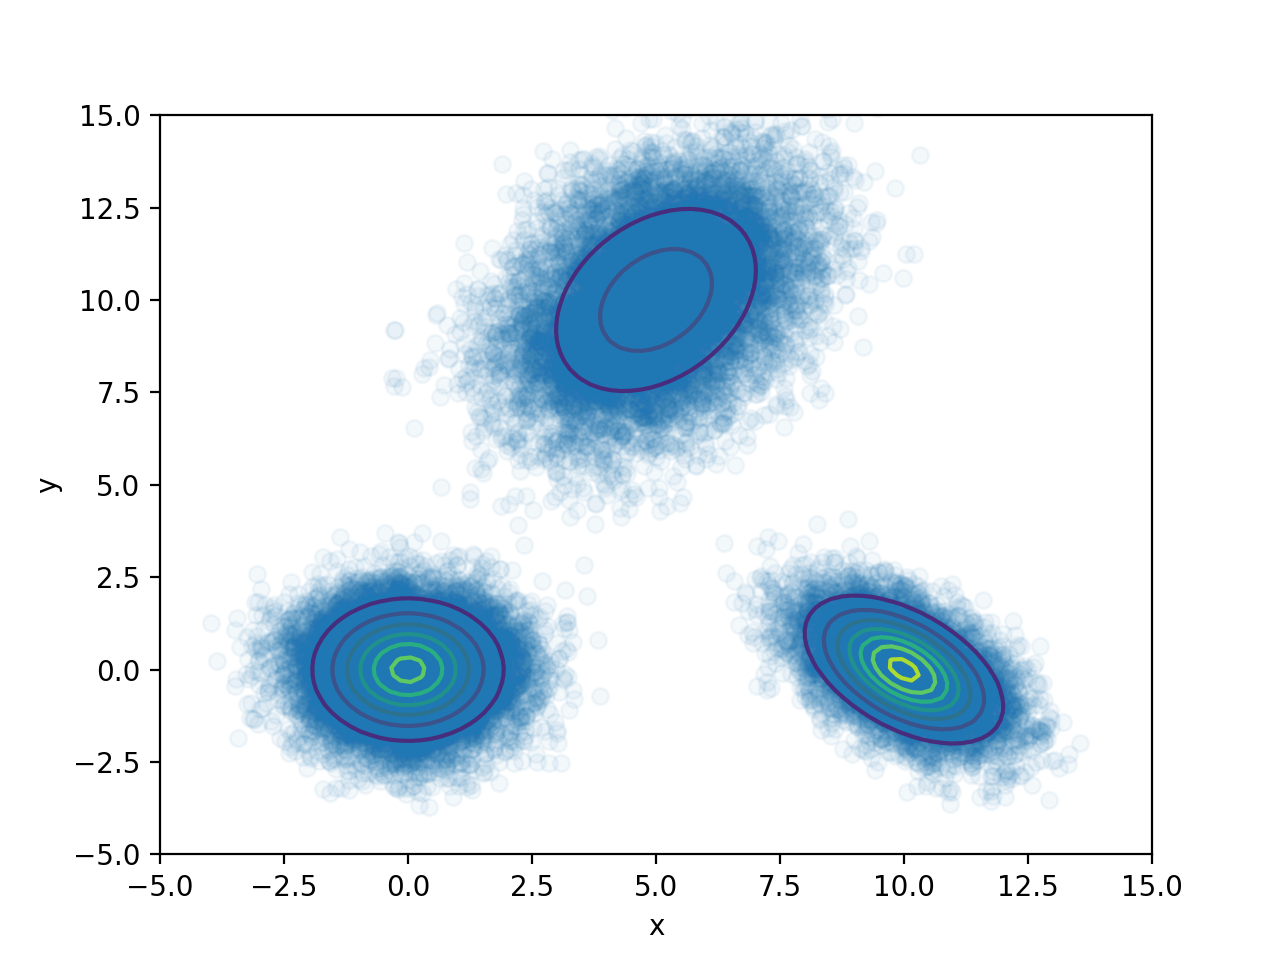

In [33]:
samples = np.vstack(chains[:, n_warmup:])

num_points = 100
x = np.linspace(-5, 15, num_points)
y = np.linspace(-5, 15, num_points)
X, Y = np.meshgrid(x, y)
Z = np.zeros(X.shape)
Z = np.exp([[log_pdf([i, j]) for i in x] for j in y])
plt.contour(X, Y, Z)
plt.scatter(samples[:,0], samples[:,1], alpha=0.05)
plt.xlim(-5, 15)
plt.ylim(-5, 15)
plt.xlabel('x')
plt.ylabel('y')
plt.show()



This problem is challenging due to the time it takes the sampler to jump between the different modes. However, performance increasees with more iterations.